#### Create a mini project using the PIMA Indian Diabetes dataset to train a neural network classifier. Include preprocessing, training, evaluation, and comparison with atleast two traditional ML models using metrics like accuracy and confusion matrix

Outline
1. Download the dataset 

In [152]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, NAdam
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import copy
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler

In [2]:
pima = pd.read_csv("diabetes.csv")

In [3]:
pima

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


### Exploratory Data Analysis

In [4]:
print(f"There a {pima[pima["Outcome"] == 1].shape[0]} positive cases and {pima[pima["Outcome"] == 0].shape[0]} negative cases")

There a 268 positive cases and 500 negative cases


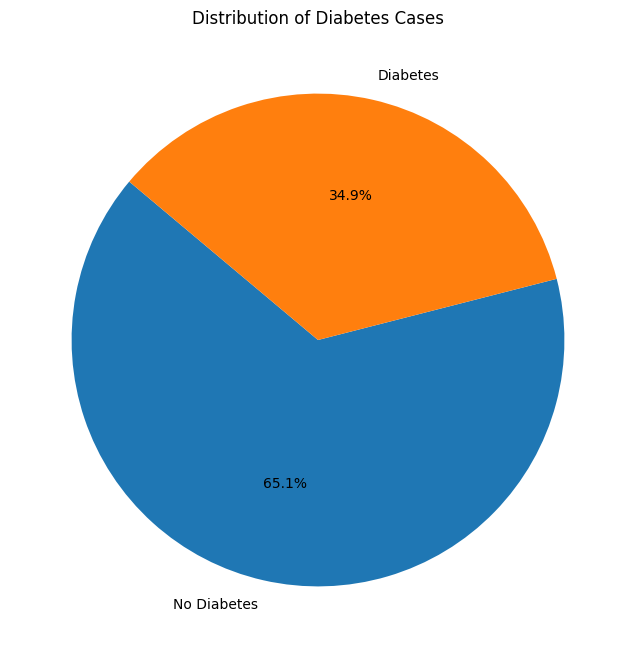

In [5]:
plt.figure(figsize=(12, 8))
plt.pie(pima["Outcome"].value_counts(), labels=["No Diabetes", "Diabetes"], autopct="%1.1f%%", startangle=140)
plt.title("Distribution of Diabetes Cases")
plt.show()


In [6]:
pima_X = pima.drop("Outcome", axis=1)
pima_y = pima["Outcome"]

Since the number of positive cases are low, we use random sampling to balance the dataset.

In [7]:
rand_sampler = RandomOverSampler(sampling_strategy=1.0, random_state=42)

In [8]:
pima_X, pima_y = rand_sampler.fit_resample(pima_X, pima_y)

In [9]:
print("Balanced dataset:")
print(f"There are {pima_X[pima_y == 1].shape[0]} positive cases and {pima_X[pima_y == 0].shape[0]} negative cases")

Balanced dataset:
There are 500 positive cases and 500 negative cases


In [10]:
pima_X

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33
...,...,...,...,...,...,...,...,...
995,1,122,64,32,156,35.1,0.692,30
996,0,131,0,0,0,43.2,0.270,26
997,8,120,0,0,0,30.0,0.183,38
998,4,111,72,47,207,37.1,1.390,56


In [11]:
pima_X.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000
mean,4.115000,125.374000,69.576000,20.832000,85.494000,32.59690,0.482551,34.155000
std,3.509714,32.341399,19.782304,16.299677,121.252093,7.76833,0.339166,11.602223
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.078000,21.000000
25%,1.000000,102.000000,64.000000,0.000000,0.000000,27.90000,0.247000,25.000000
50%,3.000000,122.000000,72.000000,24.000000,23.000000,32.50000,0.378000,31.000000
75%,7.000000,146.000000,80.000000,33.000000,140.000000,36.80000,0.645250,42.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.10000,2.420000,81.000000


In [13]:
pima_combined = pd.concat([pima_X, pima_y], axis=1)

<Figure size 1200x1200 with 0 Axes>

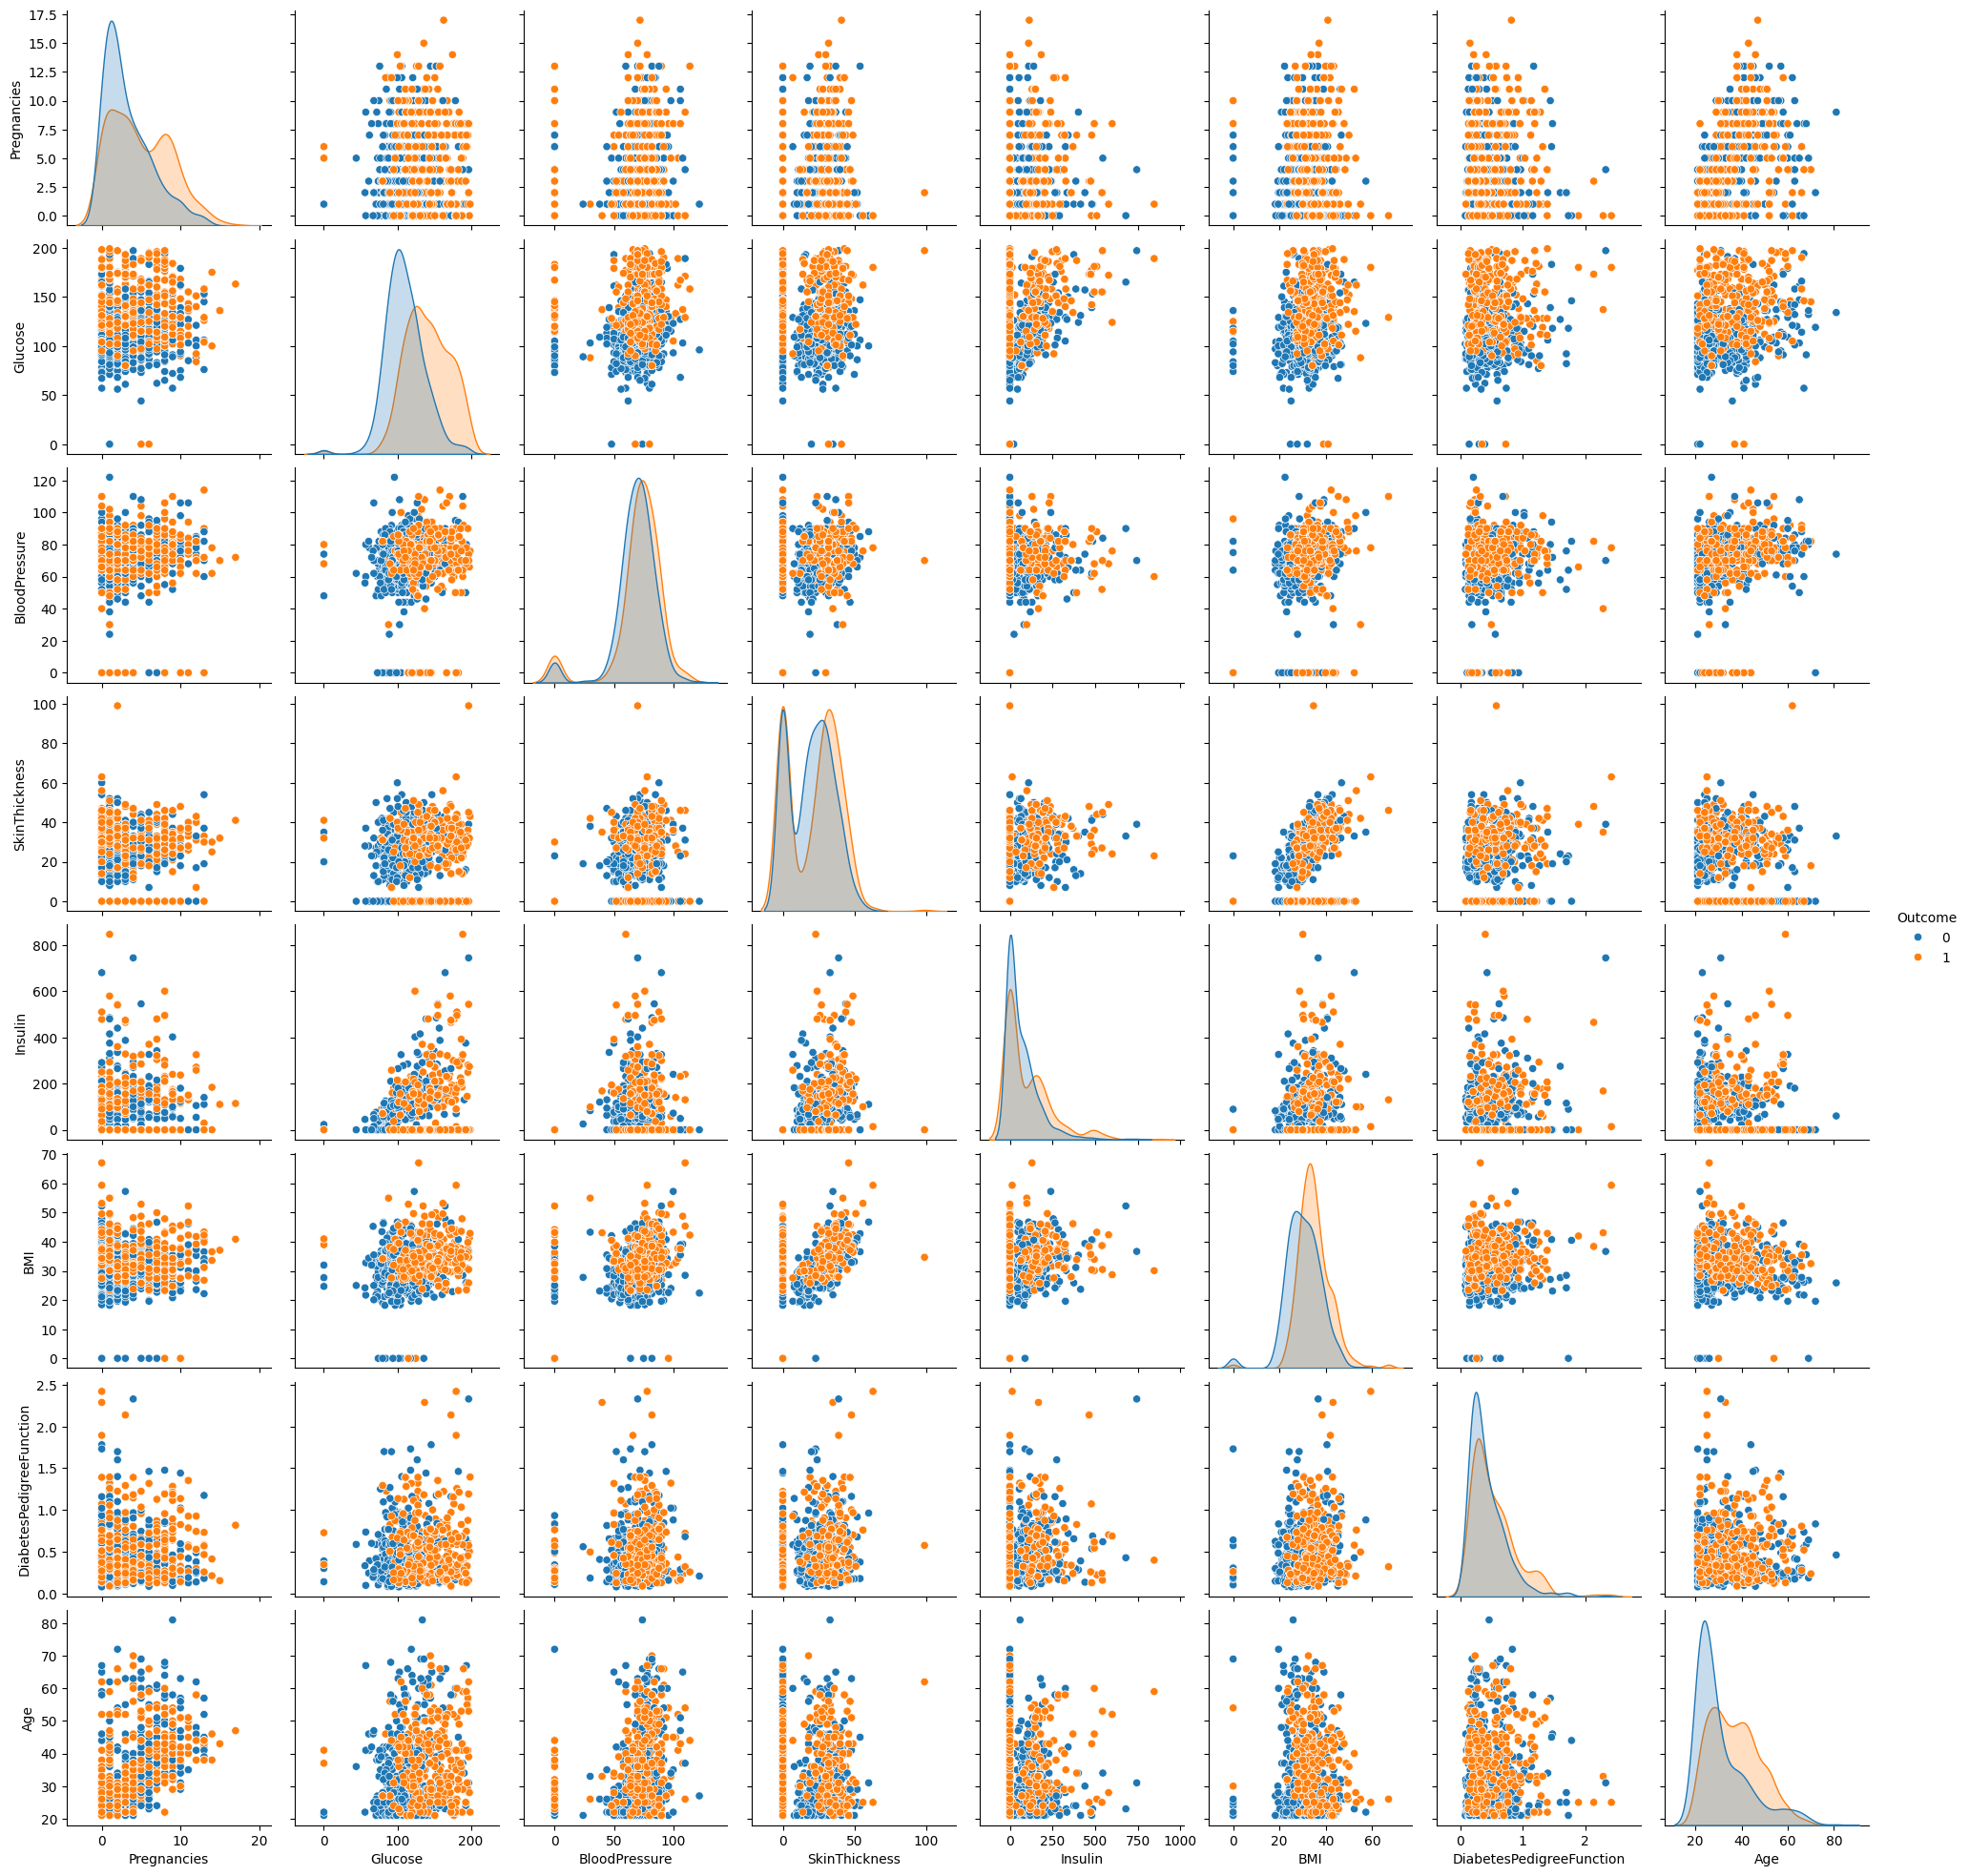

In [14]:
plt.figure(figsize=(12, 12))
sns.pairplot(pima_combined, hue="Outcome")

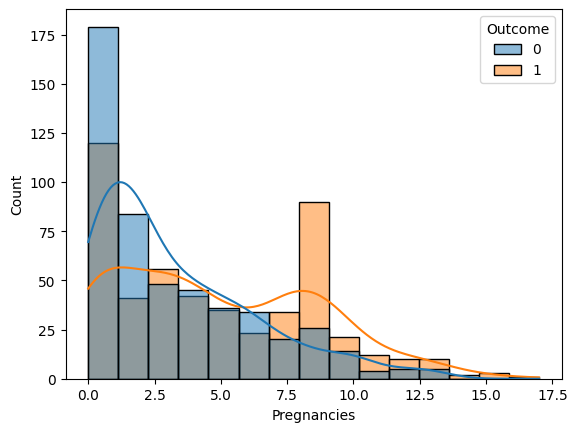

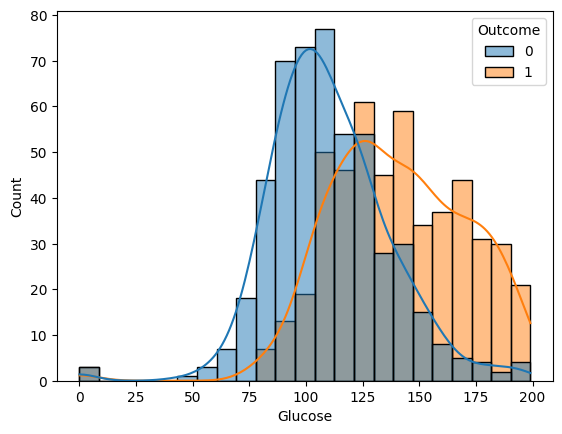

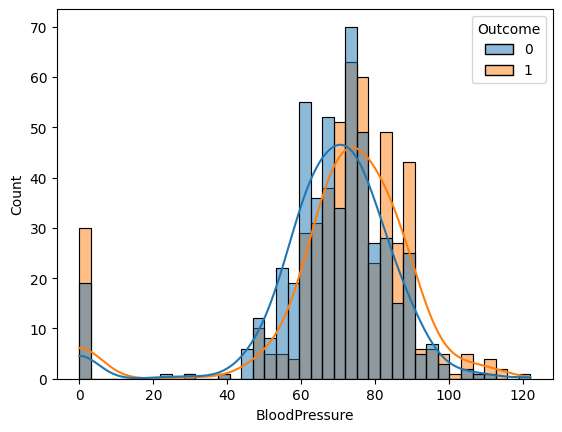

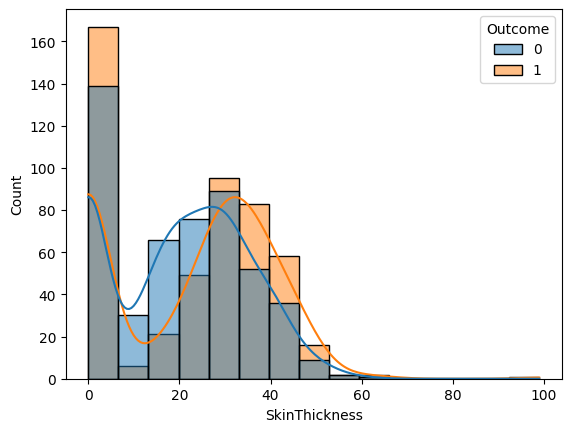

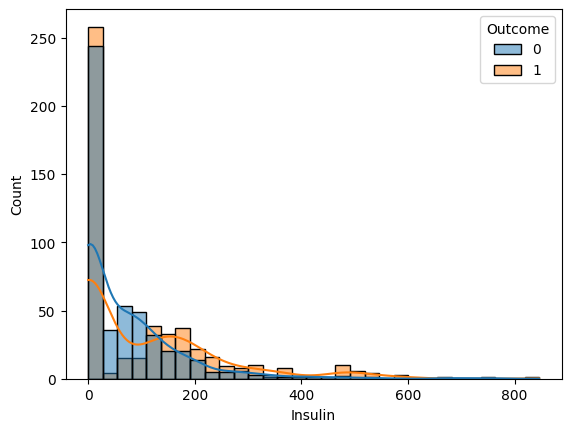

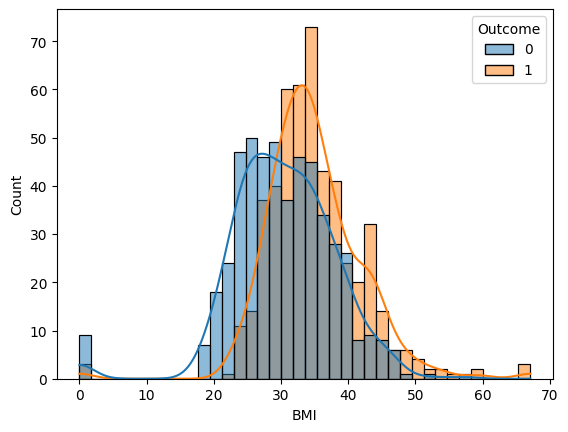

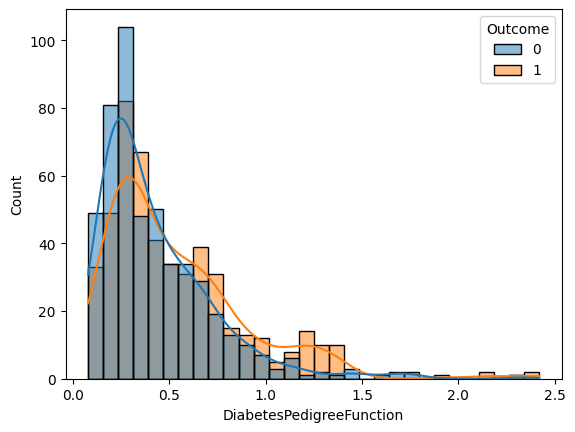

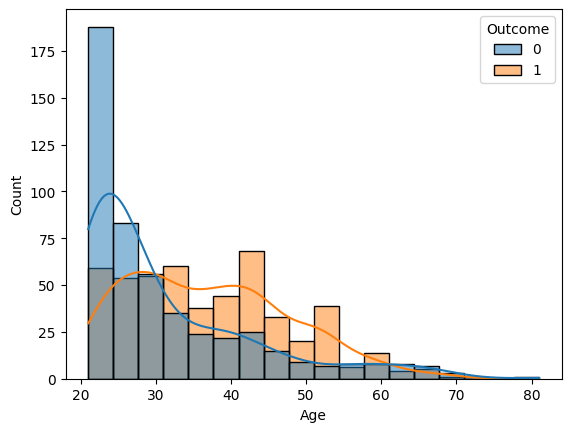

In [16]:
for col in pima_X.columns:
    plt.figure()
    sns.histplot(data=pima_combined, x=col, hue="Outcome", kde=True)

Creating Boxplots for each feature

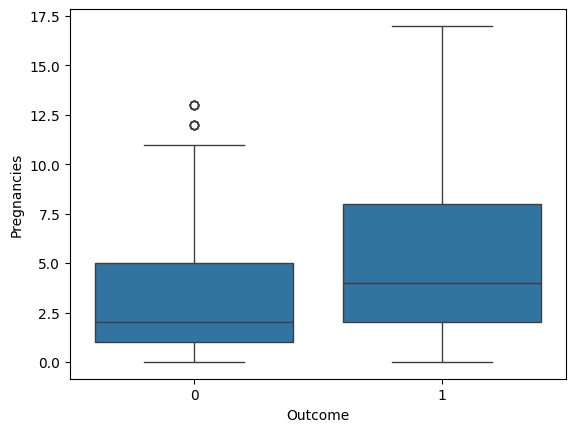

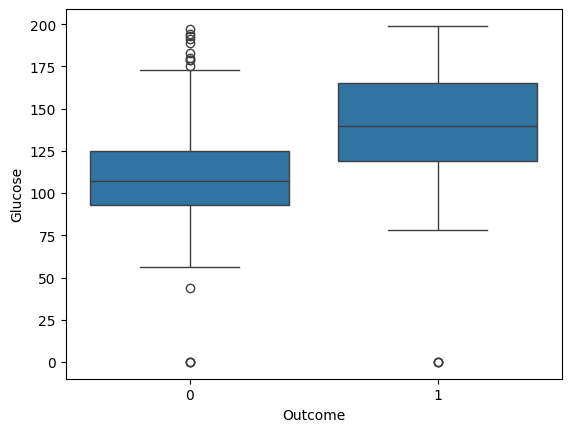

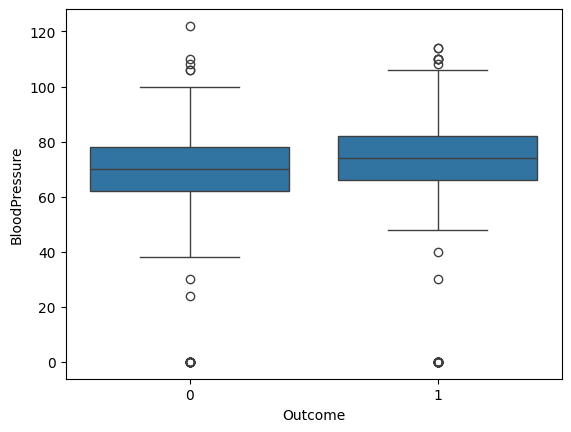

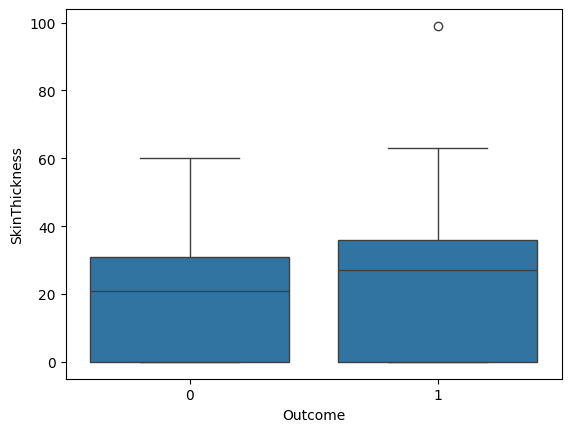

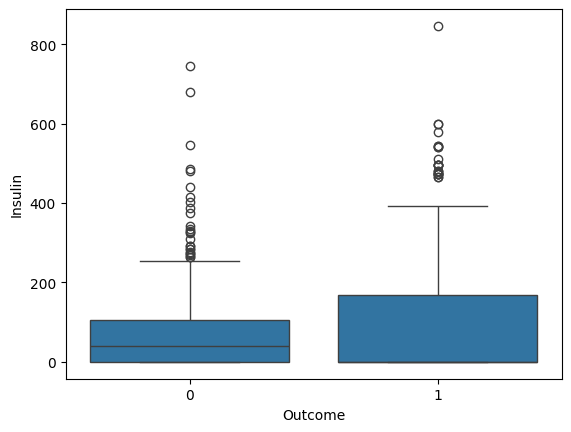

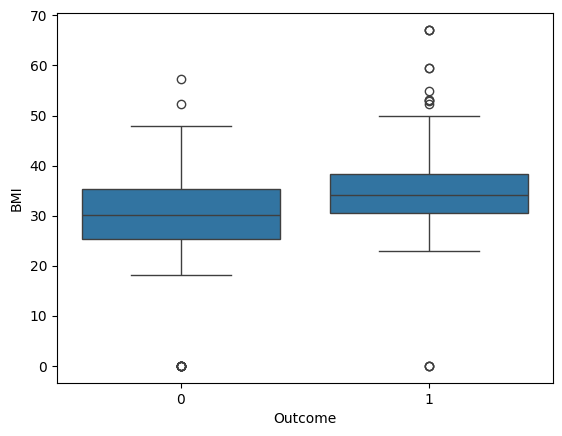

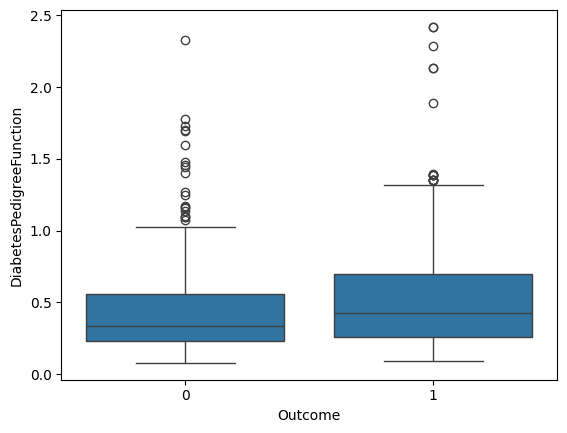

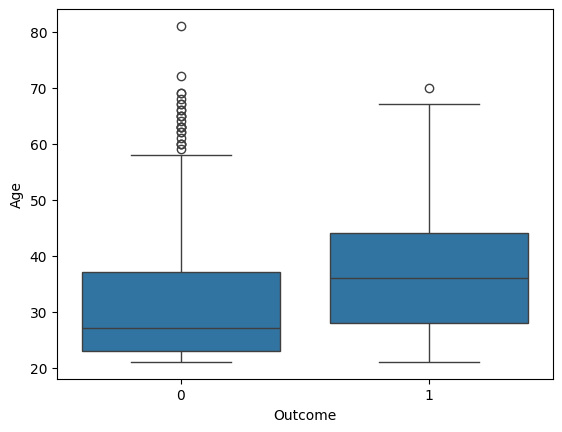

In [17]:
for col in pima_X.columns:
    plt.figure()
    sns.boxplot(data=pima_combined, x="Outcome", y=col)

Removing the outliers using the IQR method, by creating a boolean mask

In [18]:
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[(df[col] < lower_bound)] = pd.NA
        df[(df[col] > upper_bound)] = pd.NA
    return df


In [19]:
pima_X = remove_outliers(pima_X, pima_X.columns)

In [20]:
combined_df = pd.concat([pima_X, pima_y], axis=1)


In [21]:
combined_df.dropna(inplace=True)

In [22]:
pima_X = combined_df.drop("Outcome", axis=1)
pima_y = combined_df["Outcome"]

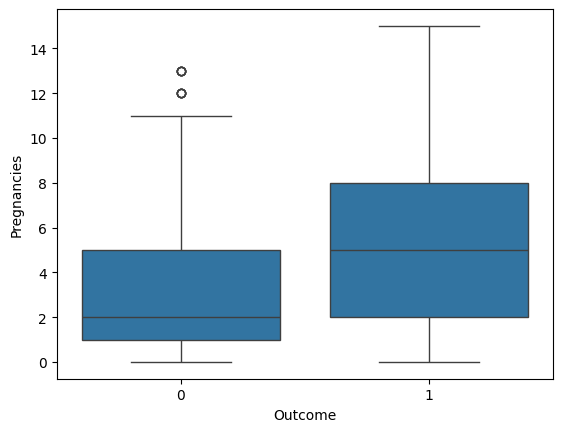

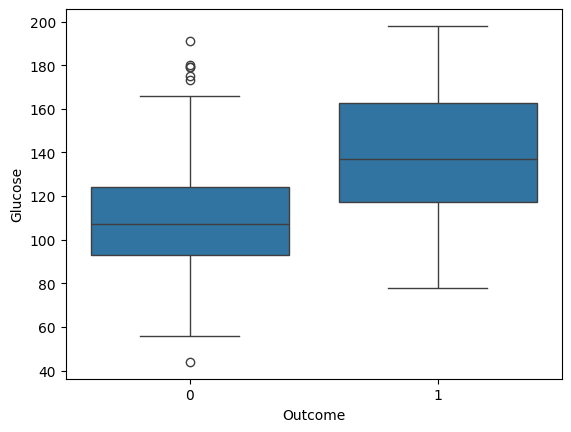

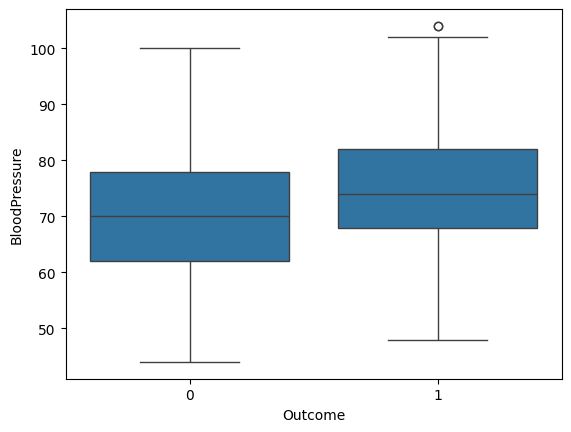

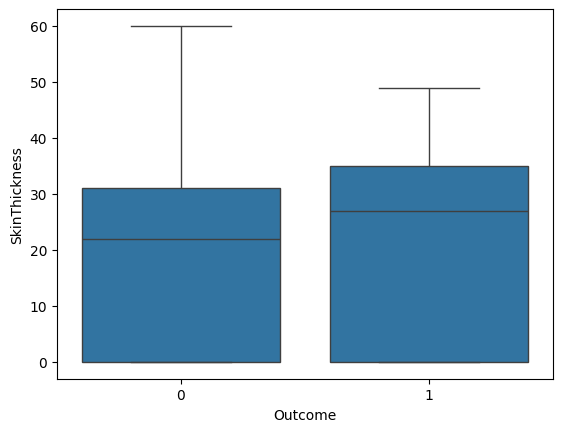

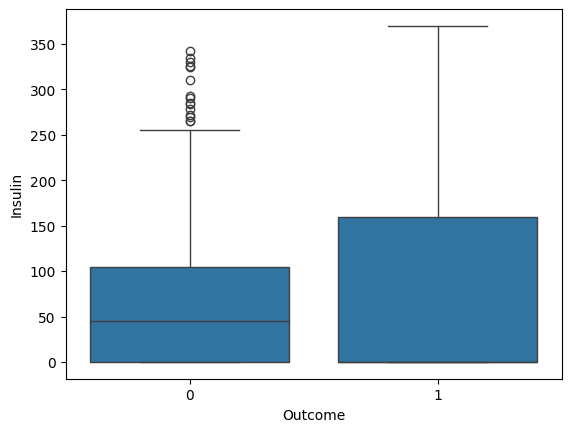

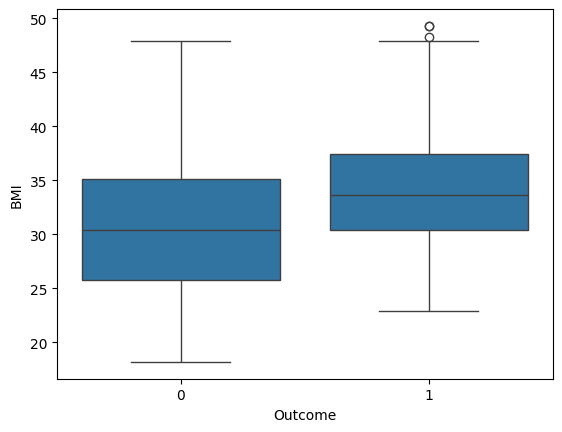

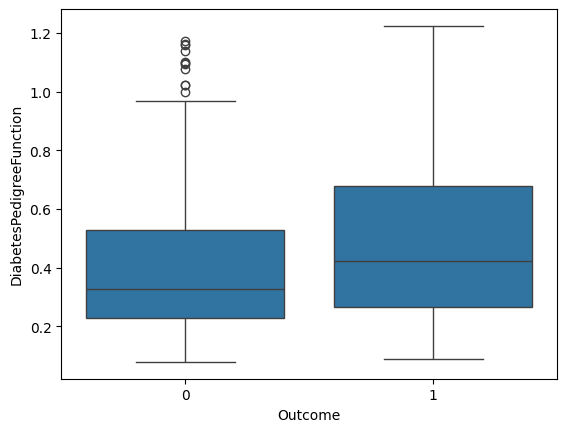

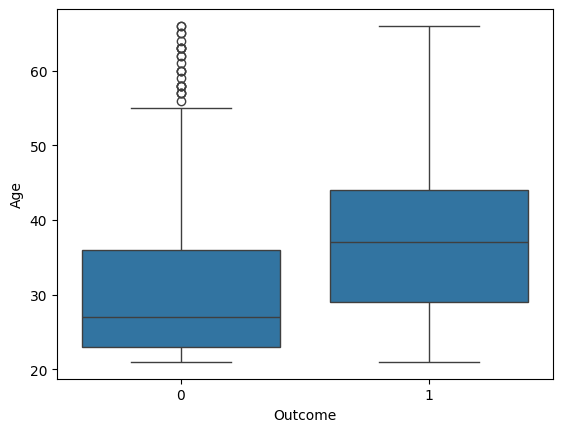

In [23]:
for col in pima_X.columns:
    plt.figure()
    sns.boxplot(data=pima_X, x=pima_y, y = col)

In [24]:
print(f"After removing outliers, there are {pima_X.shape[0]} samples left.")
print(f"There are {pima_X[pima_y == 1].shape[0]} positive cases and {pima_X[pima_y == 0].shape[0]} negative cases")

After removing outliers, there are 835 samples left.
There are 394 positive cases and 441 negative cases


Visualizing the correlation matrix

<Axes: >

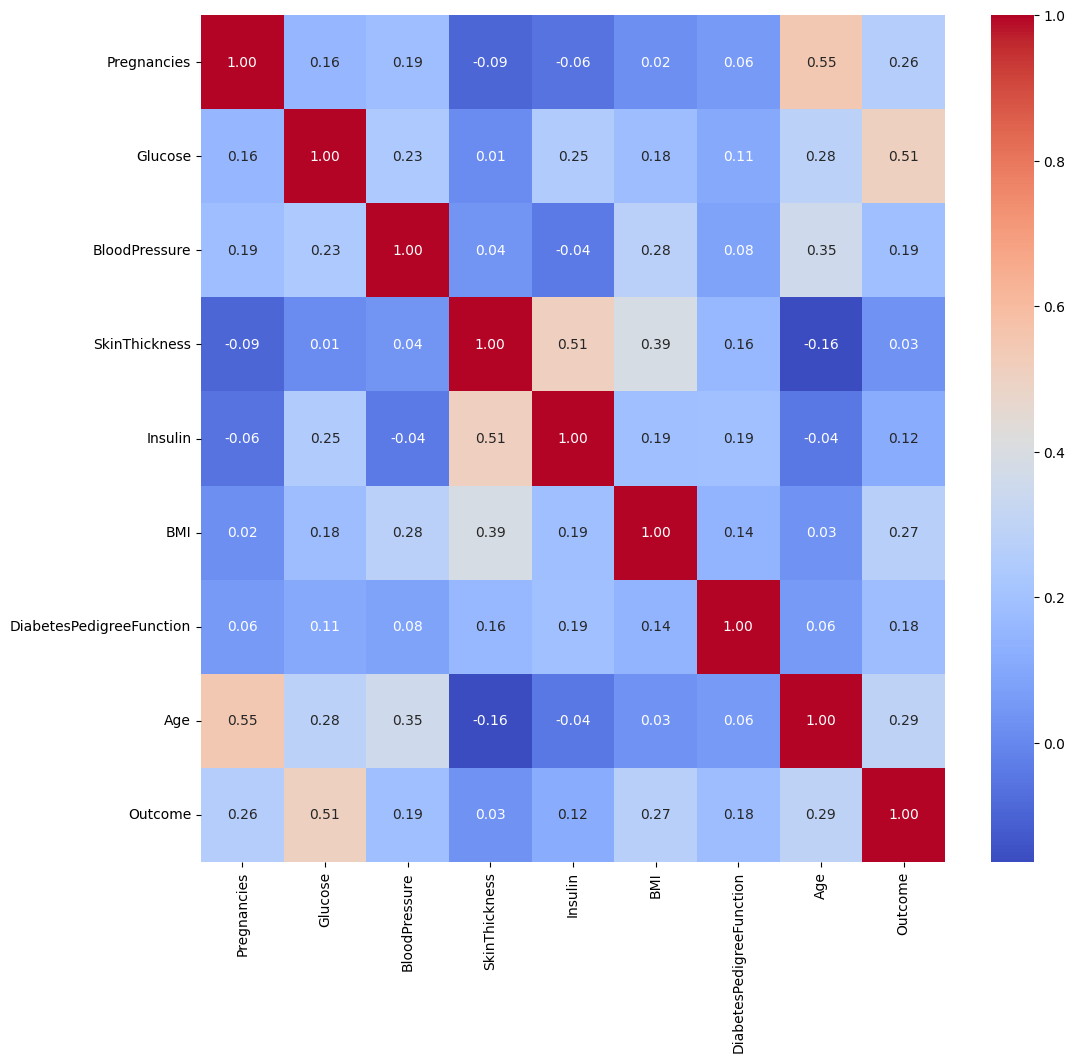

In [25]:
corr = combined_df.corr()
plt.figure(figsize=(12, 11))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")

Scaling the dataset using standard scaler

In [115]:
scaler = StandardScaler()
# pima_X_copy = scaler.fit_transform(pima_X_copy)
pima_X_scaled = scaler.fit_transform(pima_X)

Dividing the dataset into train, test and validation set

In [116]:
# X_train, X_test, y_train, y_test = train_test_split(pima_X_copy, pima_y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(pima_X_scaled, pima_y, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

#### Training an artificial neural network on the dataset

Creating a new neural network class using pytorch

In [161]:
class DiabetesModel(nn.Module):
    def __init__(self, input_size=8, hidden_size=14, output_size=1):
        super(DiabetesModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = self.out(x)
        return x
    
#hidden size = 14, accuracy = 78, act func = gelu, features = 7, lr = 0.014
#hidden size = 10, accuracy = 79, act func = relu, features = 7, lr = 0.014
#hidden size = 10, accuracy = 79, act func = leaky relu, features = 7, lr = 0.014
#hidden size = 12, accuracy = 80, act func = leaky relu, features = 7, lr = 0.014
#hidden size = 12, accuracy = 79, act func = leaky relu, features = 8, lr = 0.014
#hidden size = 14, accuracy = 80, act func = leaky relu, features = 8, lr = 0.014

In [162]:
torch.manual_seed(42)
model_01 = DiabetesModel()
model_01

DiabetesModel(
  (fc1): Linear(in_features=8, out_features=14, bias=True)
  (fc2): Linear(in_features=14, out_features=14, bias=True)
  (out): Linear(in_features=14, out_features=1, bias=True)
)

We are using cross entropy loss for calculating the loss of the model, and ADAM for optimizing the weights and biases of the model

In [163]:
loss_fn = nn.BCEWithLogitsLoss()
# optimizer = Adam(model_01.parameters(), lr=0.01)
optimizer = NAdam(model_01.parameters(), lr=0.01)

In [164]:
epochs = 400
best_model_loss = float('inf')
best_model_weights = None
patience = 5

loss_list = []
accuracy_list = []

for i in range(epochs):
    # train_loss = 0.0
    model_01.train()

    outputs = model_01(X_train_tensor)
    loss = loss_fn(outputs, y_train_tensor)
    loss_list.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_01.eval()
    with torch.no_grad():
        outputs = model_01(X_test_tensor)
        test_loss = loss_fn(outputs, y_test_tensor)
    y_pred = torch.sigmoid(outputs).round()
    accuracy = (y_pred == y_test_tensor).float().mean().item()
    accuracy_list.append(accuracy)

    if test_loss < best_model_loss:
        best_model_loss = test_loss
        best_model_weights = copy.deepcopy(model_01.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {i+1}")
            break
    print(f"Epoch {i+1}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}")


Epoch 1/400, Train Loss: 0.6923, Test Loss: 0.6869
Epoch 2/400, Train Loss: 0.6869, Test Loss: 0.6823
Epoch 3/400, Train Loss: 0.6820, Test Loss: 0.6764
Epoch 4/400, Train Loss: 0.6764, Test Loss: 0.6688
Epoch 5/400, Train Loss: 0.6694, Test Loss: 0.6588
Epoch 6/400, Train Loss: 0.6604, Test Loss: 0.6463
Epoch 7/400, Train Loss: 0.6490, Test Loss: 0.6315
Epoch 8/400, Train Loss: 0.6355, Test Loss: 0.6143
Epoch 9/400, Train Loss: 0.6199, Test Loss: 0.5949
Epoch 10/400, Train Loss: 0.6030, Test Loss: 0.5750
Epoch 11/400, Train Loss: 0.5853, Test Loss: 0.5558
Epoch 12/400, Train Loss: 0.5682, Test Loss: 0.5389
Epoch 13/400, Train Loss: 0.5522, Test Loss: 0.5242
Epoch 14/400, Train Loss: 0.5377, Test Loss: 0.5100
Epoch 15/400, Train Loss: 0.5244, Test Loss: 0.4983
Epoch 16/400, Train Loss: 0.5125, Test Loss: 0.4879
Epoch 17/400, Train Loss: 0.5018, Test Loss: 0.4791
Epoch 18/400, Train Loss: 0.4919, Test Loss: 0.4711
Epoch 19/400, Train Loss: 0.4831, Test Loss: 0.4650
Epoch 20/400, Train L

Testing the model

In [165]:
model_01.eval()
with torch.no_grad():
    outputs = model_01(X_test_tensor)
    y_pred = torch.sigmoid(outputs).round().numpy()

In [166]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.83      0.82        88
           1       0.81      0.80      0.80        79

    accuracy                           0.81       167
   macro avg       0.81      0.81      0.81       167
weighted avg       0.81      0.81      0.81       167



<Axes: >

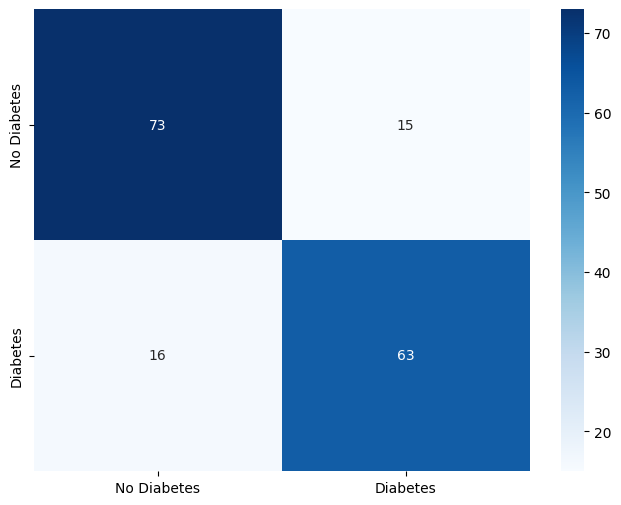

In [169]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Diabetes', 'Diabetes'], yticklabels=['No Diabetes', 'Diabetes'])

In [170]:
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

Accuracy: 0.8144


Plotting the loss and accuracy curve

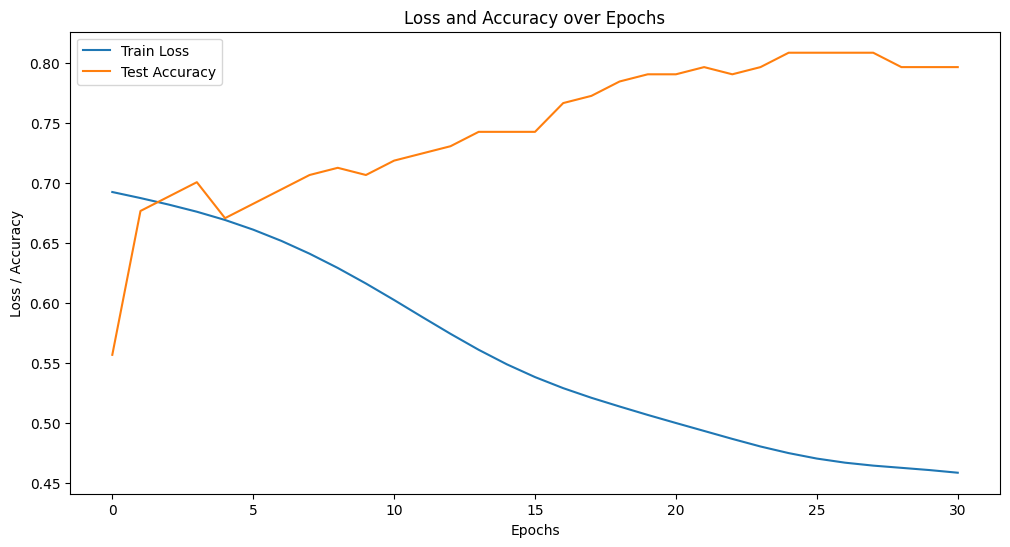

In [151]:
plt.figure(figsize=(12, 6))
sns.lineplot(x=range(len(loss_list)), y=loss_list, label='Train Loss')
sns.lineplot(x=range(len(accuracy_list)), y=accuracy_list, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss / Accuracy')
plt.title('Loss and Accuracy over Epochs')
plt.legend()
plt.show()